In [47]:
import pandas as pd
import numpy as np
import os
import maf_utils
import maf_plots

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
project_dir = "/home/data/data_dingyangliu/ASC_project_cleaned"
LUSC_dir = os.path.join(project_dir, "raw_data/LUSC_PRJNA395106/single_sample_vcf2maf")
LUAD_dir = os.path.join(project_dir, "raw_data/LUAD_PRJNA597628/single_sample_vcf2maf")

In [49]:
# lusc_maf
lusc_mafs = []
for file_name in os.listdir(LUSC_dir):
    case_ID = file_name.split('_')[0]
    lusc_mafs.append(maf_utils.read_maf(os.path.join(LUSC_dir, file_name), case_ID))

lusc_all_case_maf = pd.concat(lusc_mafs)
lusc_all_case_maf_count = lusc_all_case_maf.groupby("case_ID").size()
print(len(lusc_all_case_maf.case_ID.unique()))
filtered_lusc_all_case_maf = maf_utils.filter_maf(lusc_all_case_maf)
filtered_lusc_all_case_maf_count = filtered_lusc_all_case_maf.groupby("case_ID").size()

# save maf/filtered maf
#all_case_maf.to_csv(os.path.join(project_dir, 'ATS_11case/all_case_maf.csv'), index=False)
#filtered_all_case_maf.to_csv(os.path.join(project_dir, 'ATS_11case/filtered_all_case_maf.csv'), index=False)

97


AttributeError: module 'maf_utils' has no attribute 'filter_maf'

In [1]:
lusc_all_case_maf.Variant_Classification.unique()

NameError: name 'lusc_all_case_maf' is not defined

In [6]:
def load_data(dir, case_ID_replace=False, prefix="", suffix=""):
    mafs = []
    case_IDs = []
    for file_name in os.listdir(dir):
        case_ID = f"{prefix}{file_name.split('_')[0]}{suffix}"
        if case_ID_replace:
            case_ID = case_ID.replace(case_ID_replace[0], case_ID_replace[1])
        case_IDs.append(case_ID)
        mafs.append(maf_utils.read_maf(os.path.join(dir, file_name), case_ID))
        
    # all case maf
    all_case_maf = pd.concat(mafs)
    all_case_maf_count = all_case_maf.groupby("case_ID").size()

    # filter all case maf
    filtered_all_case_maf = maf_utils.filter_non_synonymous(all_case_maf)
    filtered_all_case_maf_count = filtered_all_case_maf.groupby("case_ID").size()

    return all_case_maf, all_case_maf_count, filtered_all_case_maf, filtered_all_case_maf_count, case_IDs

def binary_sort_key(col):
    # binary column to int
    binary_str = "".join(col.astype(int).astype(str))
    return int(binary_str, 2)

def sort_samples(pivot_table, top=10, freq_columns=["all_freq"]):
    # 確認頻率列是否存在
    if not all(col in pivot_table.columns for col in freq_columns):
        raise ValueError("Some freq_columns are not present in the pivot_table")
    
    # 刪除頻率列
    tmp_pivot_table = pivot_table.drop(columns=freq_columns)
    binary_pivot_table = tmp_pivot_table != False
    sort_order = (binary_pivot_table.head(top)
                  .apply(binary_sort_key, axis=0)  # 生成排序鍵
                  .sort_values(ascending=False)   # 排序
                  .index)                         # 提取列名作為排序順序
    
    # 按順序重新排列樣本
    sorted_samples = tmp_pivot_table[sort_order]
    
    # 將頻率列重新拼接
    sorted_table = pd.concat([sorted_samples, pivot_table[freq_columns]], axis=1)
    
    return sorted_table


In [7]:
luad_all_case_maf, luad_all_case_maf_count, luad_filtered_all_case_maf, luad_filtered_all_case_maf_count, luad_case_IDs = load_data(LUAD_dir, case_ID_replace=("P", "LUAD_"))
lusc_all_case_maf, lusc_all_case_maf_count, lusc_filtered_all_case_maf, lusc_filtered_all_case_maf_count, lusc_case_IDs = load_data(LUSC_dir, prefix="LUSC_")

print(f"lusc cases: {len(lusc_case_IDs)}, luad cases: {len(luad_case_IDs)}")

lusc cases: 98, luad cases: 89


In [26]:
luad_all_case_maf.loc[luad_all_case_maf.Hugo_Symbol == 'TP53',  "Variant_Classification"]

TP53|7675217|7675217|T|T|A                    Missense_Mutation
TP53|7674221|7674221|G|G|A                    Missense_Mutation
TP53|7676185|7676185|C|C|A                    Nonsense_Mutation
TP53|7673802|7673802|C|C|T                    Missense_Mutation
TP53|7673761|7673761|C|C|A                    Nonsense_Mutation
TP53|7673803|7673803|G|G|A                    Missense_Mutation
TP53|7675199|7675199|G|G|A                    Missense_Mutation
TP53|7676154|7676154|G|C|C                    Missense_Mutation
TP53|7676483|7676483|G|G|C                               Intron
TP53|7674887|7674887|C|C|A                    Missense_Mutation
TP53|7674180|7674180|C|C|T                          Splice_Site
TP53|7673534|7673534|C|C|G                          Splice_Site
TP53|7669911|7669911|C|C|T                               Intron
TP53|7675361|7675361|A|A|G                               Intron
TP53|7676301|7676301|G|G|T                               Intron
TP53|7676507|7676507|A|A|G              

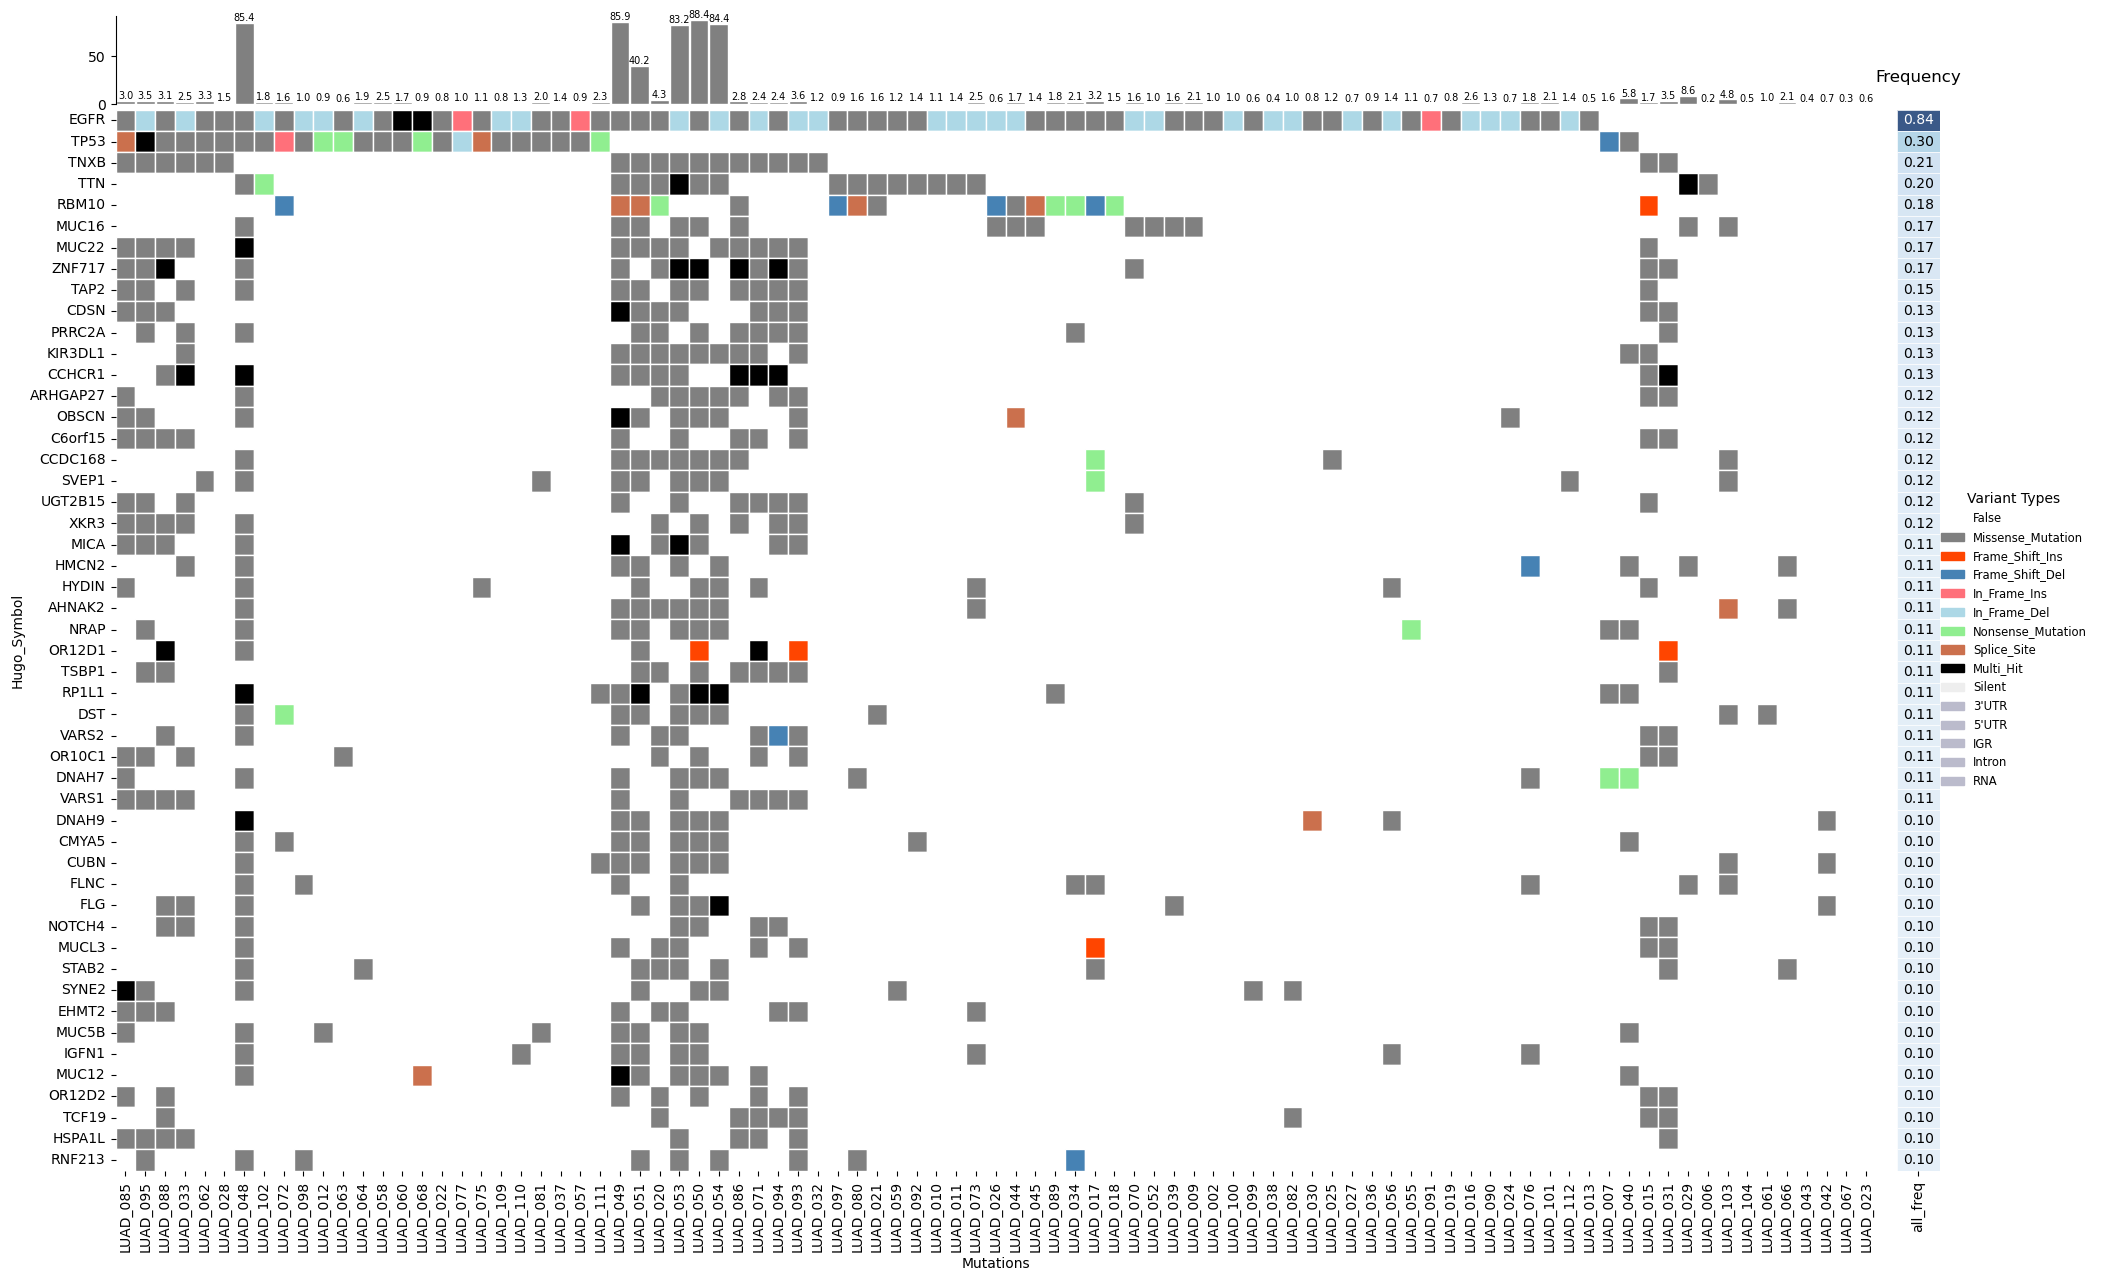

In [46]:
luad_pivot_table = maf_utils.all_case_maf_to_pivot_table(luad_filtered_all_case_maf)
sorted_luad_pivot_table = maf_utils.sort_by_variant_frequency(luad_pivot_table)
case_sorted_luad_pivot_table = sort_samples(sorted_luad_pivot_table)
maf_plots.create_oncoplot(case_sorted_luad_pivot_table.head(50),
                          figsize=(26, 15),
                          ax_main_range=(0, 28), 
                          ax_freq_range=(28, 29), 
                          ax_legend_range=(29, 31),
                          mutation_counts=luad_filtered_all_case_maf_count[case_sorted_luad_pivot_table.drop("all_freq", axis=1).columns])

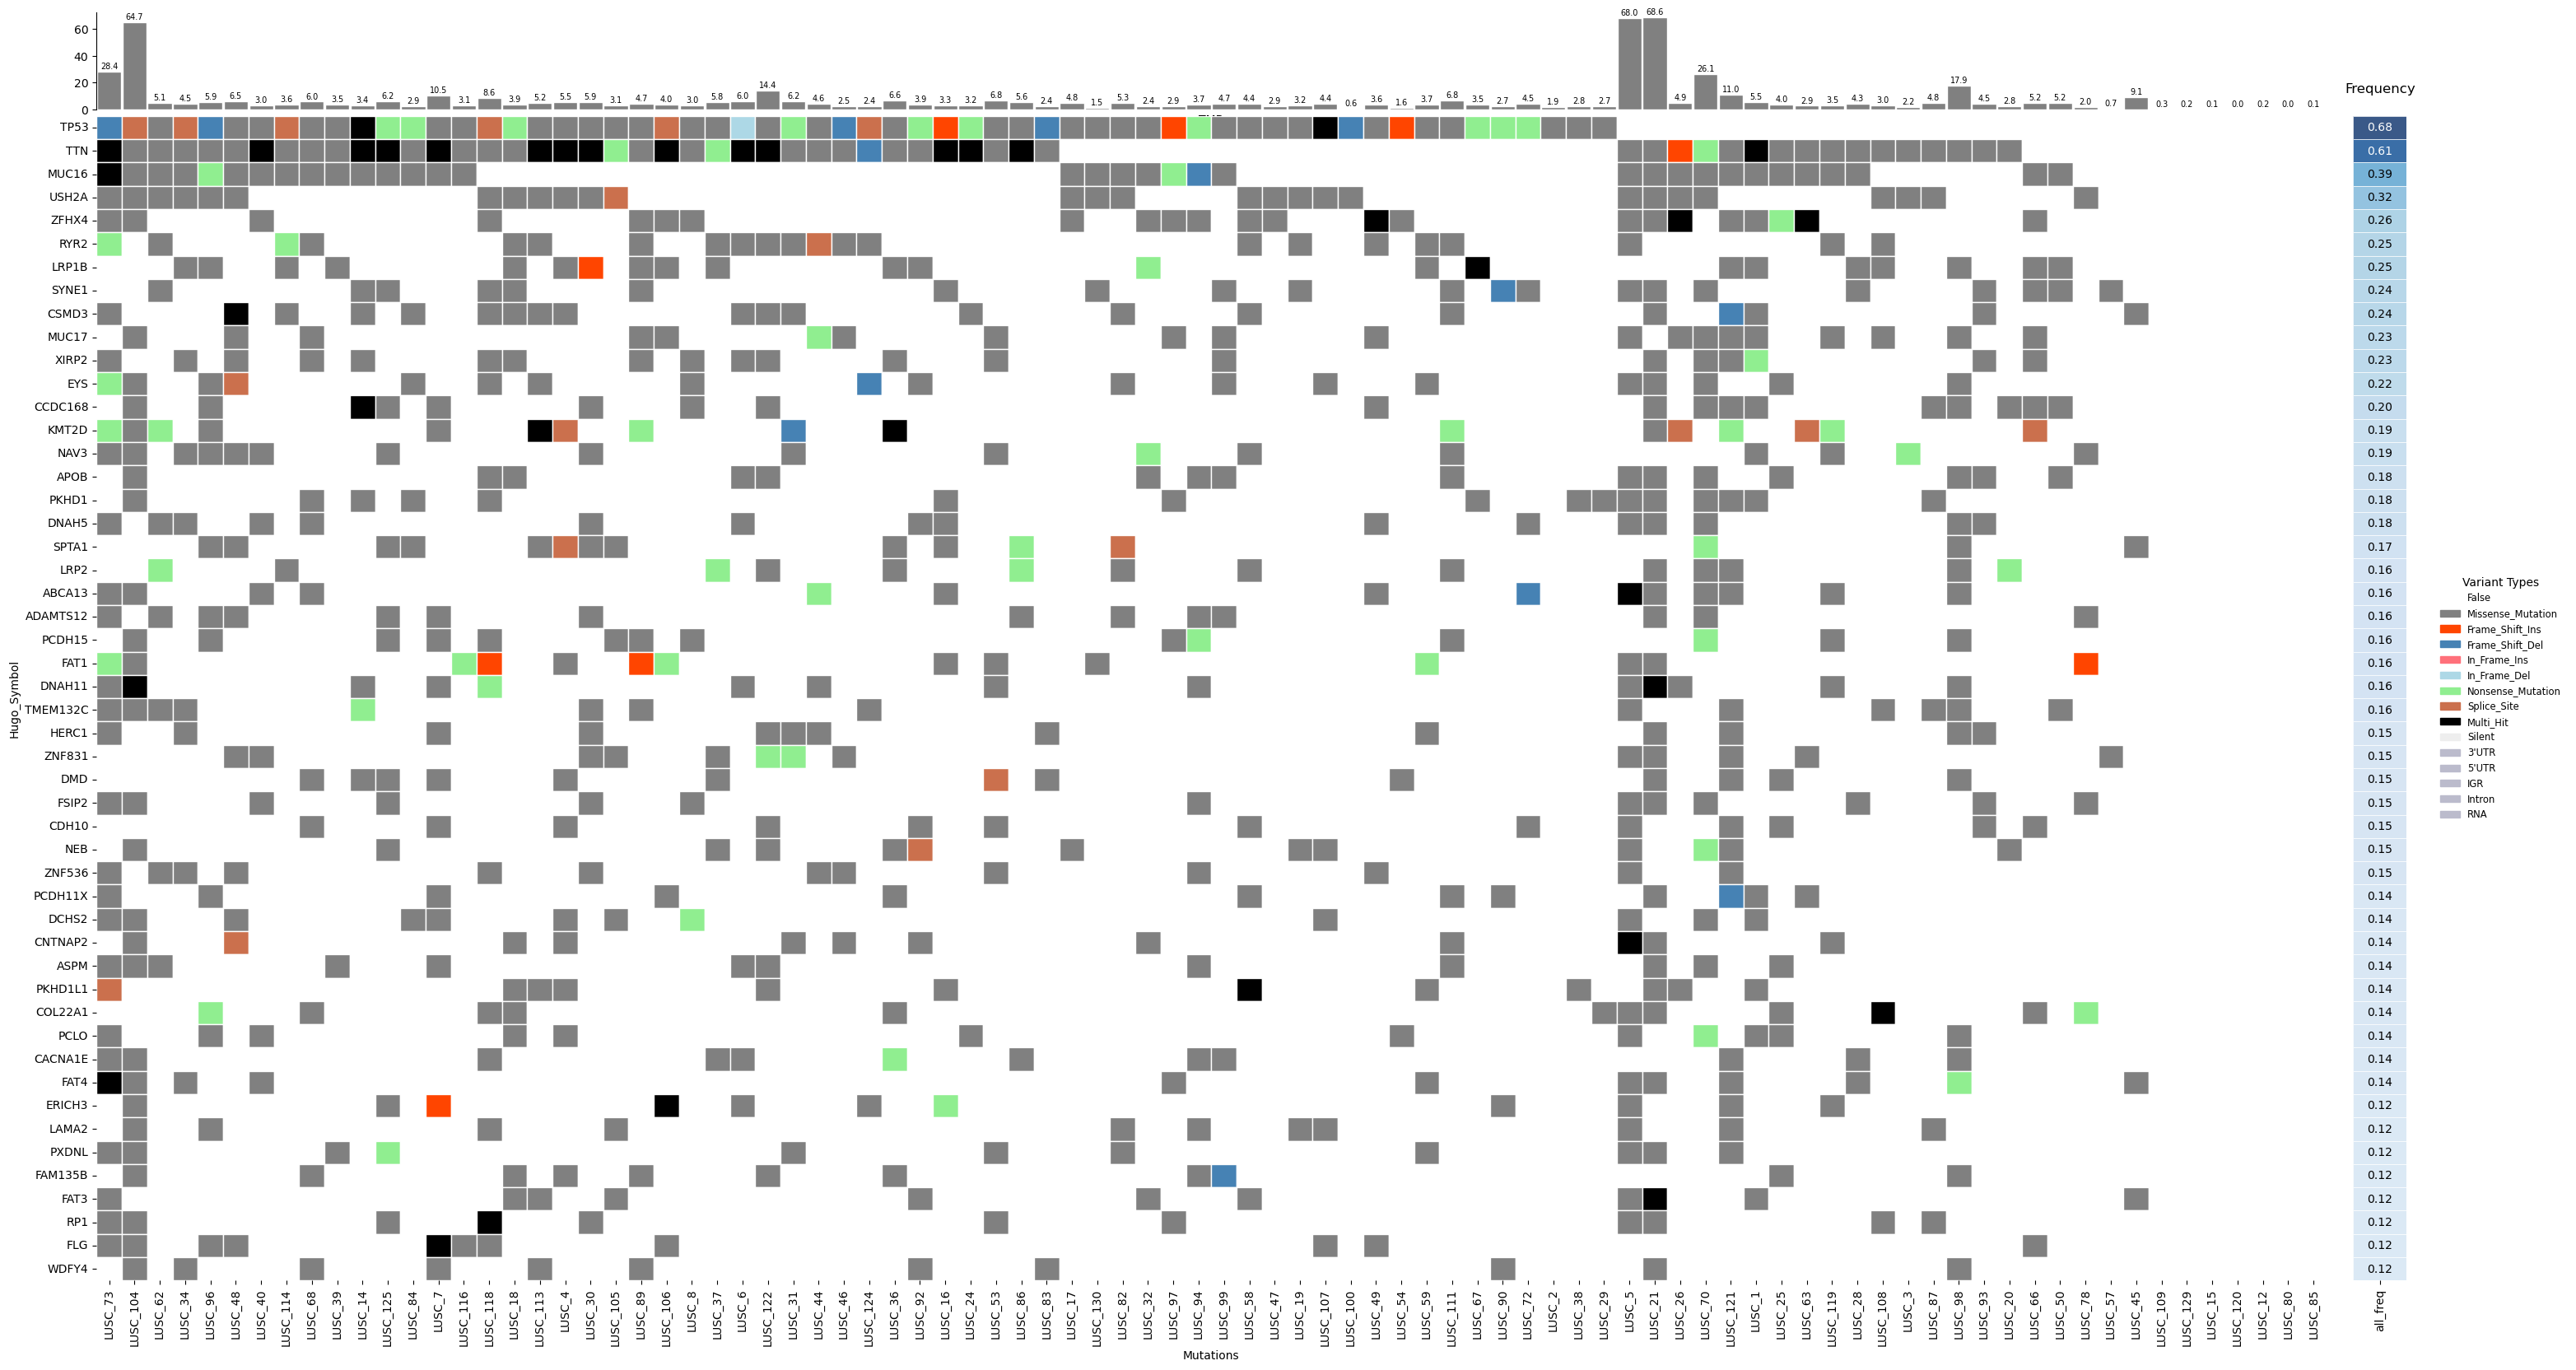

In [45]:
lusc_pivot_table = maf_utils.all_case_maf_to_pivot_table(lusc_filtered_all_case_maf)
sorted_lusc_pivot_table = maf_utils.sort_by_variant_frequency(lusc_pivot_table)
case_sorted_lusc_pivot_table = sort_samples(sorted_lusc_pivot_table)

maf_plots.create_oncoplot(case_sorted_lusc_pivot_table.head(50),
                          figsize=(40, 20),
                          ax_main_range=(0, 28), 
                          ax_freq_range=(28, 29), 
                          ax_legend_range=(29, 31),
                          mutation_counts=lusc_filtered_all_case_maf_count[case_sorted_lusc_pivot_table.drop("all_freq", axis=1).columns])

/tmp/ipykernel_245755/404575773.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_bar.set_xticklabels(bar_data.index, rotation=90)
/tmp/ipykernel_245755/404575773.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


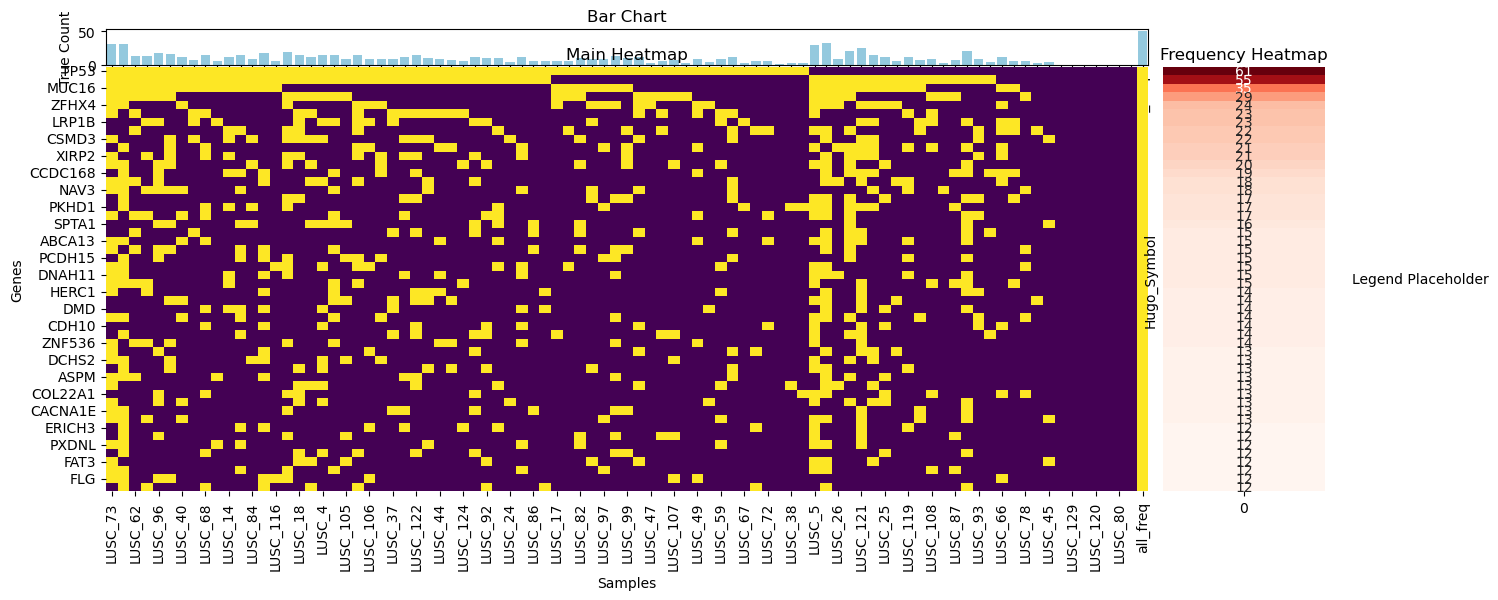

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 測試數據
heatmap_data = case_sorted_lusc_pivot_table.head(50)

# 繪圖設置
fig = plt.figure(figsize=(18, 6))
gs = plt.GridSpec(2, 32, height_ratios=[1, 12], wspace=0.5, hspace=0.01)

# 定義子圖範圍
ax_main_range = (0, 24)
ax_freq_range = (24, 28)
ax_legend_range = (29, 31)

# 創建子圖
ax_bar = fig.add_subplot(gs[0, 0:24])     # Bar chart
ax_main = fig.add_subplot(gs[1, ax_main_range[0]:ax_main_range[1]])    # Main heatmap
ax_freq = fig.add_subplot(gs[1, ax_freq_range[0]:ax_freq_range[1]])   # Frequency heatmap
ax_legend = fig.add_subplot(gs[1, ax_legend_range[0]:ax_legend_range[1]]) # Legend

# 熱圖 (主圖)
sns.heatmap(heatmap_data != False, cmap="viridis", cbar=False, ax=ax_main)
ax_main.set_title("Main Heatmap")
ax_main.set_xlabel("Samples")
ax_main.set_ylabel("Genes")

# 條形圖 (柱狀圖)
bar_data = (heatmap_data != False).sum(axis=0)  # 每列的 True 數量
sns.barplot(x=bar_data.index, y=bar_data.values, ax=ax_bar, color="skyblue")
ax_bar.set_title("Bar Chart")
ax_bar.set_ylabel("True Count")
ax_bar.set_xticklabels(bar_data.index, rotation=90)

# 頻率熱圖
freq_data = (heatmap_data != False).sum(axis=1)  # 每行的 True 數量
sns.heatmap(pd.DataFrame(freq_data), cmap="Reds", cbar=False, ax=ax_freq, annot=True)
ax_freq.set_title("Frequency Heatmap")
ax_freq.set_yticks([])  # 隱藏 y 軸標籤

# 樣例圖例
ax_legend.axis("off")  # 暫時隱藏圖例部分
ax_legend.text(0.5, 0.5, "Legend Placeholder", ha="center", va="center")

plt.tight_layout()
plt.show()


In [ ]:
def plot_bar(ax_bar, mutation_counts):    
    # Ensure the bar width exactly matches the heatmap cell width
    width = 1.0
    x = np.arange(len(mutation_counts))
    
    # Create bars
    ax_bar.bar(x, mutation_counts, width=width, color='gray', edgecolor='white', align='edge')
    
    # Set x-axis limits to exactly match the heatmap
    # The -0.5 ensures the bars align perfectly with heatmap cells
    ax_bar.set_xlim(-0.5, len(mutation_counts) - 0.5)
    
    # Hide unnecessary spines and ticks
    ax_bar.spines['top'].set_visible(False)
    ax_bar.spines['right'].set_visible(False)
    ax_bar.spines['bottom'].set_visible(False)
    ax_bar.set_xticks([])
    ax_bar.set_yticks([])

def plot_heatmap(ax_main, heatmap_data, color_map, linecolor="white", square=True, show_frame=False):
    # Create color mapping function
    def color_encode(val):
        return color_map.get(val, '#FFFFFF')

    # Transform data to color matrix
    data_matrix = heatmap_data.map(color_encode)

    # Create base heatmap to show data presence
    sns.heatmap(
        heatmap_data.notna(),
        cmap=['white', 'grey'],
        cbar=False,
        linewidths=1,
        linecolor=linecolor,
        ax=ax_main,
        square=square
    )
    
    # Rotate y-axis labels for readability
    ax_main.set_yticklabels(ax_main.get_yticklabels(), rotation=0)

    # Add colored rectangles for each cell
    for i in range(data_matrix.shape[0]):
        for j in range(data_matrix.shape[1]):
            ax_main.add_patch(plt.Rectangle(
                (j, i), 1, 1,
                fill=True,
                facecolor=data_matrix.iloc[i, j],
                edgecolor=linecolor,
                lw=1
            ))

    # Optional: add light frame every 3 samples
    if show_frame:
        for i in range(0, heatmap_data.shape[1], 3):
            rect = Rectangle(
                (i, -0.5), 3, heatmap_data.shape[0] + 1,
                linewidth=1, 
                edgecolor='lightgray', 
                facecolor='none'
            )
            ax_main.add_patch(rect)

def create_oncoplot(sorted_df, 
                    color_map=None, 
                    mutation_counts=None, 
                    figsize=(18, 16),
                    wspace=0.01,  # Reduced wspace for tighter alignment
                    hspace=0.01, 
                    freq_columns=["all_freq"], 
                    ax_main_range=(0, 24), 
                    ax_freq_range=(24, 28),
                    ax_legend_range=(29, 31),
                    square=False,
                    show_frame=False):
    
    # Default color mapping
    color_map = color_map or {
        'False': '#FFFFFF',
        'Missense_Mutation': 'gray',
        'Frame_Shift_Ins':'#FF4500',
        'Frame_Shift_Del': '#4682B4',
        'In_Frame_Ins': '#FF707A',
        'In_Frame_Del':'#ADD8E6',
        'Nonsense_Mutation': '#90EE90',
        'Splice_Site': '#CB704D',
        'Multi_Hit': '#000000',
        "Silent": "#eeeeee",
        "3'UTR": "#bbbbcc",
        "5'UTR": "#bbbbcc",
        "IGR": "#bbbbcc",
        "Intron": "#bbbbcc",
        "RNA": "#bbbbcc",
    }

    # Prepare data
    heatmap_data = sorted_df.drop(columns=freq_columns)
    freq_data = sorted_df[freq_columns].values
    
    # Create figure with precise grid specification
    fig = plt.figure(figsize=figsize)
    gs = plt.GridSpec(2, 32, height_ratios=[1, 12], wspace=wspace, hspace=hspace)
    
    # Bar chart (top subplot)
    if mutation_counts is not None:
        ax_bar = fig.add_subplot(gs[0, 0:24])
        plot_bar(ax_bar, mutation_counts)
    else:
        ax_bar = None
    
    # Main heatmap
    ax_main = fig.add_subplot(gs[1, ax_main_range[0]:ax_main_range[1]])
    ax_freq = fig.add_subplot(gs[1, ax_freq_range[0]:ax_freq_range[1]])
    ax_legend = fig.add_subplot(gs[1, ax_legend_range[0]:ax_legend_range[1]])

    # Plot components
    plot_heatmap(ax_main, heatmap_data, color_map, square=square, show_frame=show_frame)
    plot_freq(ax_freq, freq_data, freq_columns, square=square)
    plot_legend(ax_legend, color_map)

    ax_main.set_xlabel("Mutations")
    
    return fig

create_oncoplot()

In [56]:
#case_sorted_lusc_pivot_table = sort_samples(sorted_lusc_pivot_table)
tmp_pivot_table = sorted_lusc_pivot_table.drop(columns=["all_freq"])
binary_pivot_table = tmp_pivot_table != False
sort_order = (binary_pivot_table.head(10)
                  .apply(binary_sort_key, axis=0) 
                  .sort_values(ascending=False) 
                  .index)
    

sorted_samples = tmp_pivot_table[sort_order]
sorted_table = pd.concat([sorted_samples, sorted_lusc_pivot_table[["all_freq"]]], axis=1)
sorted_table

case_ID,LUSC_73,LUSC_104,LUSC_34,LUSC_4,LUSC_96,LUSC_62,LUSC_48,LUSC_114,LUSC_39,LUSC_14,...,LUSC_57,LUSC_55,LUSC_15,LUSC_129,LUSC_85,LUSC_80,LUSC_109,LUSC_12,LUSC_120,all_freq
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
TP53,Frame_Shift_Del,Splice_Site,Splice_Site,Missense_Mutation,Frame_Shift_Del,Missense_Mutation,Missense_Mutation,Multi_Hit,Missense_Mutation,Multi_Hit,...,False,False,False,False,False,False,False,False,False,0.674157
TTN,Multi_Hit,Multi_Hit,Missense_Mutation,Multi_Hit,Missense_Mutation,Missense_Mutation,Missense_Mutation,Missense_Mutation,Missense_Mutation,Multi_Hit,...,False,False,False,False,False,False,False,False,False,0.606742
MUC16,Multi_Hit,Missense_Mutation,Missense_Mutation,Targeted_Region,Nonsense_Mutation,Missense_Mutation,Missense_Mutation,Missense_Mutation,Missense_Mutation,Missense_Mutation,...,False,False,False,False,False,False,False,False,False,0.393258
USH2A,Missense_Mutation,Missense_Mutation,Missense_Mutation,Missense_Mutation,Missense_Mutation,Missense_Mutation,Missense_Mutation,False,False,False,...,False,False,False,False,False,False,False,False,False,0.325843
LRP1B,Targeted_Region,Targeted_Region,Missense_Mutation,Missense_Mutation,Missense_Mutation,False,False,Missense_Mutation,Multi_Hit,False,...,False,False,False,False,False,False,False,False,False,0.292135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FAF2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.011236
FAHD1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.011236
FAM107A,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.011236


In [ ]:
def binary_sort_key(col):
    # 將列轉為二進制字符串後轉為整數
    binary_str = "".join(col.astype(int).astype(str))
    return int(binary_str, 2)

def sort_samples(pivot_table, top=10, freq_columns=["all_freq"]):
    # 確認頻率列是否存在
    if not all(col in pivot_table.columns for col in freq_columns):
        raise ValueError("Some freq_columns are not present in the pivot_table")
    
    tmp_pivot_table = pivot_table.drop(columns=freq_columns)
    binary_pivot_table = tmp_pivot_table != False
    sort_order = (binary_pivot_table.head(top)
                  .apply(binary_sort_key, axis=0) 
                  .sort_values(ascending=False) 
                  .index)
    
    sorted_samples = tmp_pivot_table[sort_order]
    sorted_table = pd.concat([sorted_samples, pivot_table[freq_columns]], axis=1)
    return sorted_table



case_ID,all_freq,LUSC_73,LUSC_104,LUSC_34,LUSC_4,LUSC_96,LUSC_62,LUSC_48,LUSC_114,LUSC_39,...,LUSC_45,LUSC_57,LUSC_109,LUSC_55,LUSC_129,LUSC_15,LUSC_80,LUSC_120,LUSC_12,LUSC_85
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
TP53,0.674157,Frame_Shift_Del,Splice_Site,Splice_Site,Missense_Mutation,Frame_Shift_Del,Missense_Mutation,Missense_Mutation,Multi_Hit,Missense_Mutation,...,False,False,False,False,False,False,False,False,False,False
TTN,0.606742,Multi_Hit,Multi_Hit,Missense_Mutation,Multi_Hit,Missense_Mutation,Missense_Mutation,Missense_Mutation,Missense_Mutation,Missense_Mutation,...,False,False,False,False,False,False,False,False,False,False
MUC16,0.393258,Multi_Hit,Missense_Mutation,Missense_Mutation,Targeted_Region,Nonsense_Mutation,Missense_Mutation,Missense_Mutation,Missense_Mutation,Missense_Mutation,...,False,False,False,False,False,False,False,False,False,False
USH2A,0.325843,Missense_Mutation,Missense_Mutation,Missense_Mutation,Missense_Mutation,Missense_Mutation,Missense_Mutation,Missense_Mutation,False,False,...,False,False,False,False,False,False,False,False,False,False
LRP1B,0.292135,Targeted_Region,Targeted_Region,Missense_Mutation,Missense_Mutation,Missense_Mutation,False,False,Missense_Mutation,Multi_Hit,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FAF2,0.011236,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
FAHD1,0.011236,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
FAM107A,0.011236,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
class MAF:
    def __init__(self) -> None:
        self.df = pd.DataFrame()
        self.count